# Fashion MNIST by using CNN with Pytorch
<b><i>201920948 신주현</i></b>


### 0. 개발환경 구축

In [ ]:
# 개발환경 구축
!pip3 install torchinfo
!pip3 install pytorchcv
!pip3 install torchsummary
!pip3 install torchvision

### 1. 모듈 import

In [123]:
# torch
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# torchvision
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# torchsummary의 summary 함수 사용하여 요약정보 출력
from torchsummary import summary

# 그 외 라이브러리
import time
import numpy as np
import matplotlib.pyplot as plt
import gzip
import struct
import numpy as np

### 2. 변수 설정

In [124]:
# 학습 반복횟수: 10번 반복
NUM_EPOCHS = 10

# 모델에 입력으로 주어지는 데이터의 개수: 한 번에 4개의 데이터 입력
BATCH_SIZE = 4

# 학습속도: 매개변수를 갱신할 때마다 각 매개변수를 0.001씩 업데이트
LEARNING_RATE = 0.001

### 3. 전처리 과정

In [157]:
transform = transforms.Compose([
    
    # 이미지 데이터를 3차원(Tensor) 형태로 변환
    transforms.ToTensor(),

    # 정규화 변환
    transforms.Normalize((0.5,),(0.5,))
    ])

### 4. FashionMNIST 데이터셋 로드

In [158]:
# Fashion-MNIST 데이터셋 로드
trainset = torchvision.datasets.FashionMNIST(root='./data_new', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data_new', train=False, download=True, transform=transform)

# Dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

### 5. 학습 데이터셋 분할(학습용/검증용)

In [160]:
# 학습 데이터셋을 학습용과 검증용으로 분할
train_size = int(0.5 * len(trainset))
valid_size = len(trainset) - train_size
train_dataset, valid_dataset = random_split(trainset, [train_size, valid_size])

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

# 데이터셋 크기 출력
print("학습 데이터셋 크기:", len(train_dataset))
print("검증 데이터셋 크기:", len(valid_dataset))
print("테스트 데이터셋 크기:", len(testset))

학습 데이터셋 크기: 30000
검증 데이터셋 크기: 30000
테스트 데이터셋 크기: 10000


### 6. 이미지 분류 확인

In [128]:
# 클래스 이름 목록
classes = trainset.classes

# 클래스 이름과 인덱스 매핑
class_to_idx = trainset.class_to_idx

# 클래스 이름 출력
print("[클래스 이름]")
for name in classes:
    print(name)

# 클래스 인덱스 출력
print("\n[클래스 인덱스]")
for name, idx in class_to_idx.items():
    print(f"{name}: {idx}")

[클래스 이름]
T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot

[클래스 인덱스]
T-shirt/top: 0
Trouser: 1
Pullover: 2
Dress: 3
Coat: 4
Sandal: 5
Shirt: 6
Sneaker: 7
Bag: 8
Ankle boot: 9


### 7. 클래스별 시각화

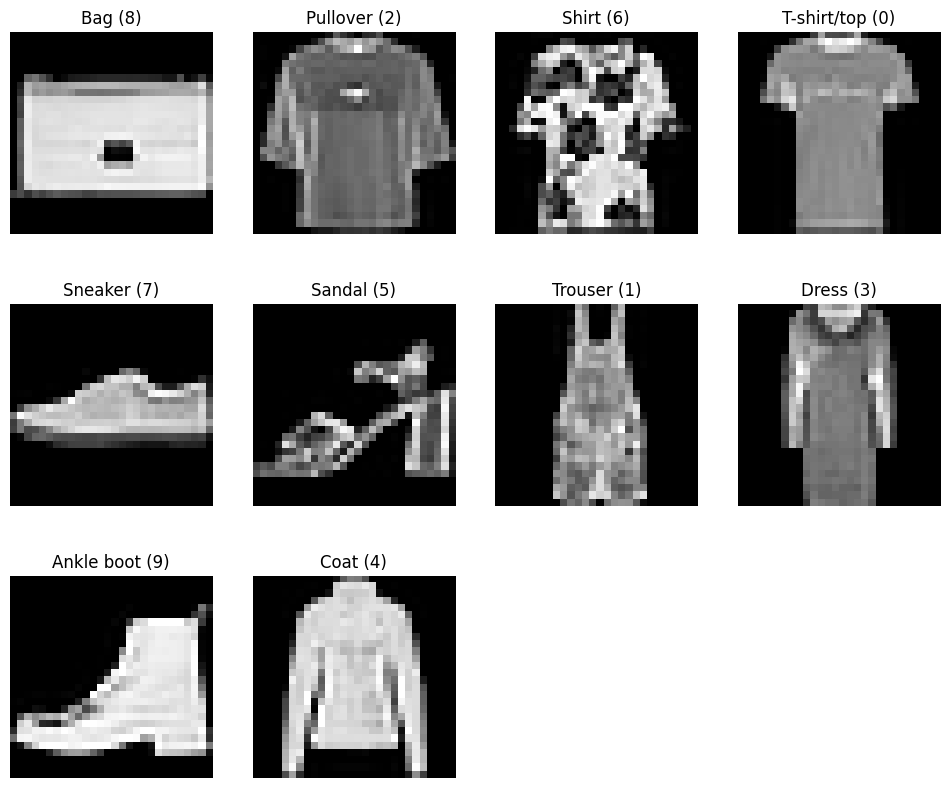

In [129]:
# 클래스별로 이미지를 저장할 딕셔너리 초기화
images_per_class = {}
labels_per_class = {}

# 모든 클래스의 이미지를 찾을 때까지 반복
for images, labels in trainloader:
    for image, label in zip(images, labels):
        label = label.item()  # 레이블을 파이썬 정수로 변환
        if label not in images_per_class:
            images_per_class[label] = image  # 해당 클래스에 대한 이미지 저장
            labels_per_class[label] = label  # 레이블 저장
        if len(images_per_class) == len(classes):  # 모든 클래스에 대한 이미지를 찾으면 반복 종료
            break
    if len(images_per_class) == len(classes):
        break

# 시각화
plt.figure(figsize=(12, 10))
for i, (label, image) in enumerate(images_per_class.items()):
    plt.subplot(3, 4, i+1)
    class_name = classes[labels_per_class[label]]  # 클래스 이름
    plt.title(f"{class_name} ({label})")  # 클래스 이름과 라벨을 제목으로 설정
    plt.imshow(image[0].numpy(), cmap='gray')  # 이미지 시각화, cmap='gray'를 통해 흑백 이미지로 표시
    plt.axis('off')
plt.show() # 출력


### 8. CNN 모델설계

In [130]:
"""
Layer 진행순서
1. Conv Layer1(5X5X6)
2. Pooling Layer1(2X2)
3. Conv Layer2(5X5X16)
4. Pooling Layer2(2X2)
5. Flattening
6. Fully Connected Layers
"""

class LeNet(nn.Module):
    # 초기화(Initiating)
    def __init__(self):
        super(LeNet, self).__init__()
        # Convolution Layer 정의
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) # 5X5 Kernal
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5) # 5X5 Kernal
        self.fc1 = nn.Linear(in_features=256, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    # 진행(Forward)
    def forward(self, x):
        # Pooling Layer 정의(Max Pooling)
        x = F.relu(self.conv1(x)) # 1번째 Convolution Layer을 통과한 결과에 ReLU active 함수 적용
        x = F.max_pool2d(x, kernel_size=2) # 2X2 Kernal
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2) # 2X2 Kernal
        
        # Feature Map을 이용하여 평탄화(Flattening)작업 진행
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # 3개의 Layer 통과후 마지막 Layer 결과 return
        x = self.fc3(x)
        return x

# LeNet 클래스 인스턴스 생성(LeNeT 모델 사용)
net = LeNet()

# 모델의 구조 출력
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 9. 장치설정 및 모델구조 출력

In [131]:
# CUDA 사용이 가능할 시, GPU를 이용해서 진행

# CUDA 사용 가능 여부 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 모델을 CUDA 장치로 이동
net = net.to(device)
# 모델 구조 출력
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 10. 손실함수 및 옵티마이저

In [132]:
# 손실함수(Loss Function)

# 모델의 출력과 실제 레이블 간의 손실 계산
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저(Optimizer)
# 모델의 파라미터 update
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9)

### 11. 학습

In [133]:
# 모델의 정확도 계산 함수

def calc_acc(loader):
    correct = 0 # 제대로 예측된 샘플
    total = 0 # 전체 샘플
    for data in loader: # 입력 이미지와 이미지의 레이블로 구성
        inputs, labels = data[0].to(device), data[1].to(device)
        # 모델 예측: 각 데이터 배치에 대해 입력 이미지를 모델에 전달하여 출력 계산
        outputs = net(inputs)
        # 예측 결과 계산: predicted는 예측된 클래스의 인덱스 포함
        _, predicted = torch.max(outputs.data, 1)
        # 정확도 계산
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return ((100 * correct)/ total)

In [137]:
# training 함수 정의
# 함수 훈련
# epoch 마다의 손실, 훈련/테스트 정확도 기록

def training():
    
    # 손실 및 정확도 초기화
    epoch_loss = [] # 각 epoch의 평균 손실
    train_acc = [] # 훈련 데이터 정확도
    test_acc = [] # 테스트 데이터 정확도
    
    # 훈련을 위한 epoch 반복 수
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0 # 누적 손실 저장용
        
        # enumerate 함수를 이용하여 train_loader에서 데이터 가져오기
        for i, data in enumerate(trainloader, 0):
            
            # 데이터에서 입력과 레이블 추출
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # 기울기(gradient) 초기화
            optimizer.zero_grad()
            
            # 예측값 얻기
            outputs = net(inputs)
            
            # 예측값과 레이블 간 손실 계산
            loss = loss_fn(outputs, labels)
            
            # 손실 역전파를 이용하여 gradient 계산
            loss.backward()
            
            # 가중치 업데이트
            optimizer.step()
            
            # 통계
            running_loss += loss.item()

        # epoch의 손실, 훈련/테스트 정확도를 리스트에 추가
        epoch_loss.append(running_loss)
        train_acc.append(calc_acc(trainloader))
        test_acc.append(calc_acc(testloader))
        
        # epoch 결과 출력
        print('Epoch: %d of %d, Train Accuracy: %0.3f%%, Test Accuracy: %0.3f%%, Loss: %0.3f'
              % (epoch+1, NUM_EPOCHS, train_acc[epoch], test_acc[epoch], running_loss/15000))
        
    # 각 epoch의 손실, 훈련/테스트 정확도 반환
    return epoch_loss, train_acc, test_acc   
    

In [138]:
# 훈련 함수 호출하여 모델 훈련 및 시간 측정

# 훈련 시작시간 저장
start = time.time()

# 모델 훈련
epoch_loss, train_acc, test_acc = training()

# 종료시간 저장
end = time.time()

# 훈련시간 분 단위로 출력
print("%0.2f Minutes" %((end-start)/60))


Epoch: 1 of 10, Train Accuracy: 87.603%, Test Accuracy: 86.520%, Loss: 0.328
Epoch: 2 of 10, Train Accuracy: 89.988%, Test Accuracy: 88.390%, Loss: 0.301
Epoch: 3 of 10, Train Accuracy: 90.713%, Test Accuracy: 88.980%, Loss: 0.281
Epoch: 4 of 10, Train Accuracy: 91.343%, Test Accuracy: 89.240%, Loss: 0.264
Epoch: 5 of 10, Train Accuracy: 91.470%, Test Accuracy: 89.300%, Loss: 0.254
Epoch: 6 of 10, Train Accuracy: 91.485%, Test Accuracy: 89.320%, Loss: 0.243
Epoch: 7 of 10, Train Accuracy: 90.667%, Test Accuracy: 88.450%, Loss: 0.233
Epoch: 8 of 10, Train Accuracy: 91.630%, Test Accuracy: 88.920%, Loss: 0.225
Epoch: 9 of 10, Train Accuracy: 92.913%, Test Accuracy: 89.700%, Loss: 0.218
Epoch: 10 of 10, Train Accuracy: 92.680%, Test Accuracy: 89.480%, Loss: 0.209
6.04 Minutes


### 12. 훈련 및 손실 시각화

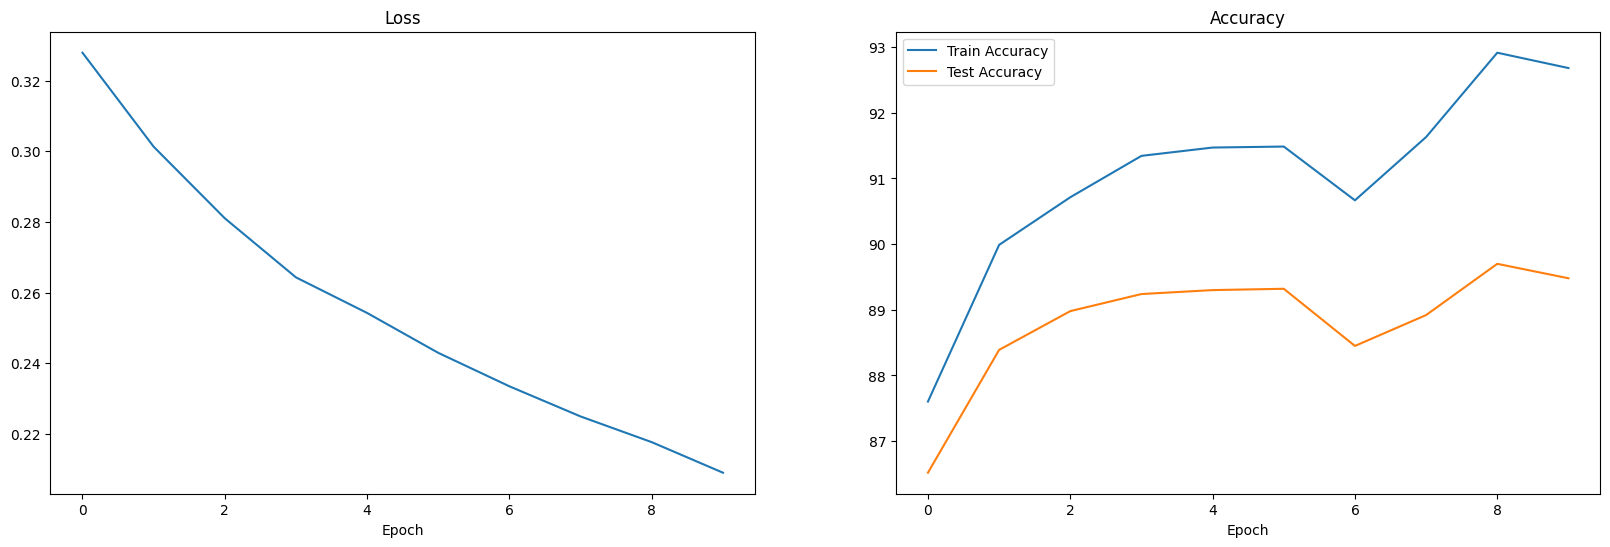

In [161]:
# 훈련 기록내용 시각화
# 영역 3열로 분할(subplot): 손실(loss), 훈련 정확도(train_acc), 테스트 정확도(test_acc)

# 그래프 크기 지정
plt.figure(figsize=(20,6)) # 가로 20 / 세로 6

# 손실(loss) 기록
plt.subplot(1,2,1) # 2열 중 첫 번째 열로 변경
plt.plot([loss/15000 for loss in epoch_loss])
plt.title("Loss")
plt.xlabel('Epoch')
# plt.ylabel('Loss') # 필요 시 주석 해제

# 정확도(accuracy) 기록: 훈련 정확도와 테스트 정확도 함께 표시
plt.subplot(1,2,2) # 2열 중 두 번째 열
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title("Accuracy")
plt.xlabel('Epoch')
plt.legend() # 레이블을 표시하기 위한 범례 추가

plt.show()

### 13. 결과 평가 및 분석

Accuracy of Test dataset : 89.48%
Most misclassified Class: Shirt


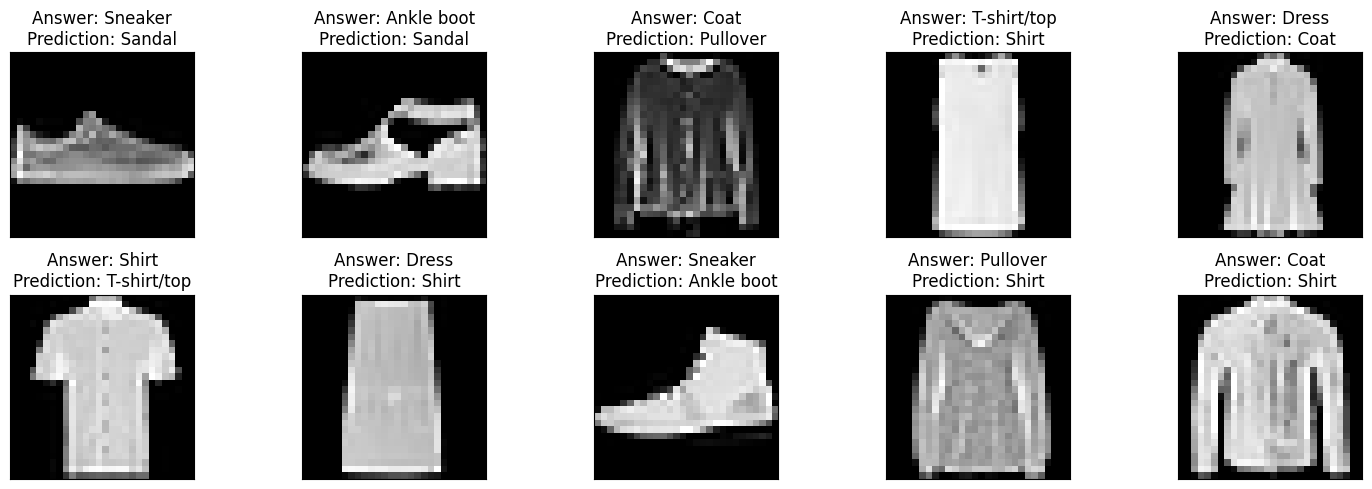

In [156]:
# 모델 평가 모드 설정
net.eval()

# 정확도 계산을 위한 변수 초기화
correct = 0
total = 0
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

# 평가 과정에서 기울기 계산을 비활성화
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 잘못 분류된 이미지 식별
        mask = (predicted != labels)
        misclassified_images.extend(images[mask])
        misclassified_labels.extend(labels[mask])
        misclassified_preds.extend(predicted[mask])

# 정확도 출력
accuracy = 100 * correct / total
print(f'Accuracy of Test dataset : {accuracy:.2f}%')

# 잘못 분류된 이미지의 클래스 분석
misclassified_counts = np.zeros(len(classes))
for label in misclassified_labels:
    misclassified_counts[label] += 1

# 가장 많이 잘못 분류된 클래스 식별
most_misclassified_class = classes[np.argmax(misclassified_counts)]
print(f'Most misclassified Class: {most_misclassified_class}')

# 잘못 분류된 이미지 몇 개 시각화
plt.figure(figsize=(15, 5))
for i in range(min(10, len(misclassified_images))):
    plt.subplot(2, 5, i+1)
    img = misclassified_images[i].squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f'Answer: {classes[misclassified_labels[i]]}\nPrediction: {classes[misclassified_preds[i]]}')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()
